# **1. Environment Setup**

In [83]:
# # Install necessary packages
# !pip install numpy pandas seaborn category_encoders Jinja2 joblib streamlit ipykernel shap sklearn

# # Save dependencies
# !pip freeze > requirements.txt


In [84]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# 2. Imports and Data Loading

In [85]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
import shap


# Suppress warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("data/predictive_maintenance.csv")


# 3. Data Preprocessing

In [86]:
def preprocess_data(df):
    df = df.drop(["UDI", "Product ID"], axis=1)
    df["Air temperature [K]"] -= 272.15
    df["Process temperature [K]"] -= 272.15
    df.rename(columns={"Air temperature [K]": "Air temperature [°C]",
                       "Process temperature [K]": "Process temperature [°C]"},
              inplace=True)
    df["Temperature difference [°C]"] = df["Process temperature [°C]"] - df["Air temperature [°C]"]
    return df

df = preprocess_data(df)


# Class division

In [87]:
for col in df[['Type','Target','Failure Type']]:
    print(df[col].value_counts())
    print("****"*8)

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
********************************
Target
0    9661
1     339
Name: count, dtype: int64
********************************
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64
********************************


# 4. Feature Engineering and Encoding

In [88]:
def encode_features(df):
    ordinal_cols = ['Type', 'Failure Type']
    ordinal_encoder = OrdinalEncoder(cols=ordinal_cols)
    df = ordinal_encoder.fit_transform(df)
    return df, ordinal_encoder

df, ordinal_encoder = encode_features(df)


# 5. Data Splitting

In [89]:
X = df.drop(columns=["Failure Type", "Target"], axis=1)
y = df["Failure Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)


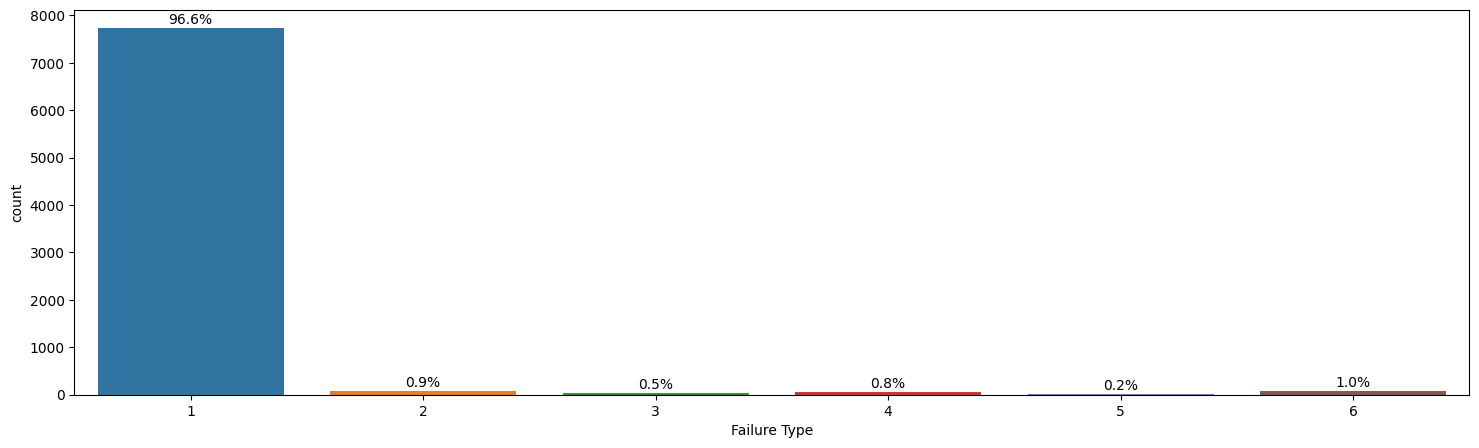

In [90]:
plt.figure(figsize=(18,5))
ax = sns.countplot(x = y_train, palette = 'tab10')
t= len(y_train)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

In [91]:
X_test.shape

(2000, 7)

# 6. Model Creation

In [92]:
model = LogisticRegression()

# 7. Model Training and Evaluation

              precision    recall  f1-score   support

           1       0.96      1.00      0.98      1921
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00         9
           4       0.57      0.25      0.35        16
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00        32

    accuracy                           0.96      2000
   macro avg       0.26      0.21      0.22      2000
weighted avg       0.93      0.96      0.94      2000



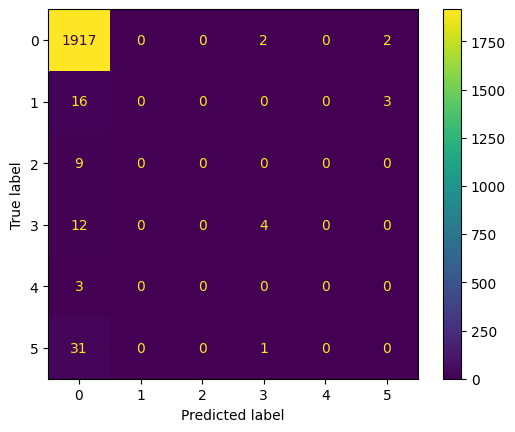

In [93]:
# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()


# 8. Actual v/s Predicted

In [94]:
prediction1 = model.predict(X_test)

# prediction1 = logreg.predict(X_test)
print(prediction1)

cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction1})
cross_checking.sample(5).style.set_properties(**{
            'color': 'LightBlue',
            'font-size': '15px'
        })

[1 1 1 ... 1 1 1]


,Actual,Predicted
3087,1,1
8668,1,1
4222,1,1
2525,1,1
6822,1,1


In [95]:
joblib.dump(model, 'models/model.joblib')
joblib.dump(ordinal_encoder, 'models/ordinal_encoder.joblib')


['models/ordinal_encoder.joblib']

# 9. Inference Function

In [96]:
def inference(row, model, ordinal_encoder, feat_cols):
    df = pd.DataFrame([row], columns=feat_cols)
    prediction = model.predict(df)
    return prediction[0]

# Example usage
model, ordinal_encoder = joblib.load('models/model.joblib'), joblib.load('models/ordinal_encoder.joblib')
feat_cols = X.columns
row = [1, 25, 35, 1550, 42, 0, 10]
result = inference(row, model, ordinal_encoder, feat_cols)


In [97]:
print(result)

1
